# Historical flooding regimes in Albufera Natural Park (Valencia, Spain)

Avian species are affected by the flooding timing of rice fields in the Albufera Natural Park, in Spain. This script analyzes the dynamics of winter rice field flooding using all available Landsat images. 
Water is identified using individual Landsat images classified using three different water detection algorithms. A consensus rule is used to identify water. 

Water area is then aggregated at a lower level study unit and its variation whithin every year and between years is studied. 

The output of the script is a table with water area per study unit and date, and visual analysis is provided for temporal changes. 

In [61]:
import ee
import geemap
import pprint
from matplotlib import pyplot as plt
import pandas as pd
import os
import numpy as np
from celluloid import Camera

#geemap.update_package()

In [62]:
# Initialise (don't need maybe?)
ee.Initialize()
# Configure the pretty printing output & initialize earthengine
pp = pprint.PrettyPrinter(depth=4)

In [63]:
Map = geemap.Map(center=[39.3,-0.37], zoom=11)
Map.add_basemap('HYBRID')
Map

Map(center=[39.3, -0.37], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children…

## Input shapefiles (reads from GEE assets)

In [64]:
# Read analysis units within Albufera and plot

unidades_shp = 'users/luiscartor/albuferaunits'
unidades = geemap.ee.FeatureCollection(unidades_shp)
Map.addLayer(unidades, {}, 'Unid. Ambientales')

# Read shapefile of all units as one polygon
allunits_shp = 'users/luiscartor/albuferaall'
allunits = geemap.ee.FeatureCollection(allunits_shp)
Map.addLayer(allunits, {}, 'All units')

In [65]:
#roi = ee.FeatureCollection(Map.draw_features)
roi = unidades

## Adding Landsat collections

In [66]:
# Function to add year attribute
def addyear(img):
    return img.set('year', ee.Image(img).date().get('year'))

# Function to add month attribute
def addmonth(img):
    return img.set('month', ee.Image(img).date().get('month'))

# Function to add Day Of Year attribute
def addDOY(img):
    return img.set('DOY', ee.Image(img).date().getRelative('day', 'year'))

# Landsat 5, only for months of December, January, February
L5_dec = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR') \
    .filterBounds(unidades) \
    .select('B[1-7]','pixel_qa') \
    .map(addyear) \
    .map(addmonth) \
    .map(addDOY) \
    .filterMetadata('month', 'equals', 12)

L5_janfeb = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR') \
    .filterBounds(unidades) \
    .select('B[1-7]','pixel_qa') \
    .map(addyear) \
    .map(addmonth) \
    .map(addDOY) \
    .filterMetadata('month', 'less_than', 3)

L5_winter = L5_dec.merge(L5_janfeb)

# Print number of images       
#print(L5_winter.size().getInfo())

# Landsat 7, only for months of December, January, February
L7_dec = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR') \
    .filterBounds(unidades) \
    .select('B[1-7]','pixel_qa') \
    .map(addyear) \
    .map(addmonth) \
    .map(addDOY) \
    .filterMetadata('month', 'equals', 12)

L7_janfeb = ee.ImageCollection('LANDSAT/LE07/C01/T1_SR') \
    .filterBounds(unidades) \
    .select('B[1-7]','pixel_qa') \
    .map(addyear) \
    .map(addmonth) \
    .map(addDOY) \
    .filterMetadata('month', 'less_than', 3)

L57_winter = L5_dec.merge(L5_janfeb).merge(L7_dec).merge(L7_janfeb)

### Check collections properties

In [67]:
# Get the number of images
countL57 = L57_winter.size()
print('L57 Winter Count: ', str(countL57.getInfo())+'\n')

# Get the number of images per year
# Define a list of unique observation years from the image collection.
yearsL57 = ee.List(L57_winter.aggregate_array('year')).distinct().sort();
print('L57_winter Years:', str(yearsL57.getInfo())+'\n')

# Map over the list of years to build a list of annual image composites.
# Function to creat comp list
def yearimlistL57(year):
    return L57_winter.filterMetadata('year', 'equals', year).size()

imagesperyearL57 = yearsL57.map(yearimlistL57)
print('Images per year L57_winter:', str(imagesperyearL57.getInfo())+'\n')

L57 Winter Count:  376

L57_winter Years: [1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

Images per year L57_winter: [2, 5, 7, 8, 8, 7, 11, 13, 8, 9, 9, 8, 10, 7, 9, 15, 18, 20, 19, 8, 14, 11, 7, 13, 5, 10, 12, 11, 8, 8, 10, 11, 9, 11, 10, 10, 10, 5]



### Plot images per year

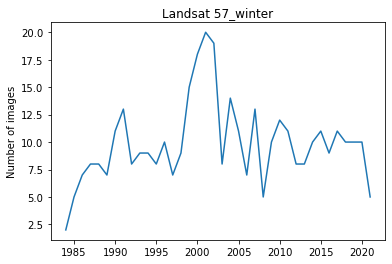

In [68]:
# Create vectors from year and images x year lists
imxyearL57vec = [[i] for i in imagesperyearL57.getInfo()]

yearsL57vec = [[i] for i in yearsL57.getInfo()]

# Plots
plt.plot(yearsL57vec,imxyearL57vec)
plt.title('Landsat 57_winter')
plt.ylabel('Number of images')
plt.show()

# Collection pre-processing
### Masking functions

In [69]:
# Function to mask clouds, cloud shadow and snow, based on the pixel_qa band of Landsat SR data
# Parameters for masking function (move to preamble)

def landsatmasking(img):

  qa = img.select('pixel_qa')
  # If the cloud bit (5) is set and the cloud confidence (7) is high
  # or the cloud shadow bit is set (3), then it's a bad pixel.
  cloudorsnow = qa.bitwiseAnd(1 << 5). \
    And(qa.bitwiseAnd(1 << 7)). \
    Or(qa.bitwiseAnd(1 << 3)). \
    Or(qa.bitwiseAnd(1 << 4))  
  # Remove edge pixels that don't occur in all bands
  mask2 = img.mask().reduce(ee.Reducer.min())
  return img.updateMask(cloudorsnow.Not()).updateMask(mask2)


# L57_winter Collection: cloud masking + snow masking
L57_winter_masked = L57_winter.map(landsatmasking)

### Visualize pre-processed images

In [70]:
Map2 = geemap.Map(center=[39.3,-0.37], zoom=11)
Map2.add_basemap('HYBRID')
Map2

Map(center=[39.3, -0.37], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children…

In [71]:
# Visualization properties
L_vis = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 0.0,
    'max': 3000.0,
    'gamma': 1.4,
}
# Add layer
#Map2.addLayer(L57_winter.first(), L_vis, 'L57_first')
#Map2.addLayer(L57_winter_masked.first(), L_vis, 'L57_masked')

# Check image with zero values 
zeroimage = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR') \
    .filterBounds(unidades) \
    .filterDate('2000-12-14', '2000-12-16') \
    .map(landsatmasking)
Map2.addLayer(zeroimage, L_vis, 'zeroimage')


# Spectral indeces extraction

In [72]:
# Spectral indices function. Adds index as a new band to every image
def addINDICES(img):
    
    ndvi = img.normalizedDifference(['B4', 'B3']).rename('NDVI')
    lswi = img.normalizedDifference(['B4', 'B5']).rename('LSWI') # same as ndwi
    ndsi = img.normalizedDifference(['B2', 'B5']).rename('NDSI') # same as mndwi
    
    # I multiply by scale factor for EVI (DIDNT WORK TO SOLVE HIGH VALUES ISSUE)
    evi = img.expression(
    '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
        'NIR': img.select('B4').multiply(0.0001),
      'RED': img.select('B3').multiply(0.0001),
      'BLUE': img.select('B1').multiply(0.0001)
    }).rename('EVI')
    
    # Feyisa (2014) Automated Water Extraction Index (AWEI) (non shadow)
    awei = img.expression(
    '(4 * (GREEN - SWIR)) - (0.25 * NIR + 2.75 * SWIR2)', {
        'GREEN': img.select('B2').multiply(0.0001),
      'SWIR': img.select('B5').multiply(0.0001),
      'NIR': img.select('B4').multiply(0.0001),
      'SWIR2': img.select('B7').multiply(0.0001)
    }).rename('AWEI')
    
    return img.addBands(ndvi).addBands(lswi).addBands(ndsi).addBands(evi).addBands(awei)

# Calculate indices to collection
L57_winter_indices = L57_winter_masked.map(addINDICES)

# Visualize indices
index_vis = {
    'bands': ['LSWI'],
    'min': 0.0,
    'max': 1.0,
    'gamma': 1.4,
}

Map2.addLayer(L57_winter_indices.median(), index_vis, 'L57_LSWI')

## Classify water layer

In [73]:
# METHOD 1
# From Kaptue et al. 2013, (africa), if NDVI<0 and MNDWI (ndsi)>0, then water. BUT TRY MORE METHODS!
def addWATER_m1(img):    
    water = img.expression(
    "(ndvi < 0) & (ndsi > 0) ? 1\
    :0",{'ndvi': img.select('NDVI'),'ndsi': img.select('NDSI')}).rename('WATER1')
    
    return img.addBands(water)

# METHOD 2
# From Feyisa et. al. 2014, serveral continents: Automated Water Extraction Index (AWEI)
def addWATER_m2(img):    
    water = img.expression(
    "(awei > 0) ? 1\
    :0",{'awei': img.select('AWEI')}).rename('WATER2')
    
    return img.addBands(water)

# METHOD 3
# From Xu 2016, simple ndsi (modified water index) threshold
def addWATER_m3(img):    
    water = img.expression(
    "(ndsi > 0) ? 1\
    :0",{'ndsi': img.select('NDSI')}).rename('WATER3')
    
    return img.addBands(water)


# Add water bands based on conditions
water_3methodscol = L57_winter_indices.map(addWATER_m1).map(addWATER_m2).map(addWATER_m3).select(['WATER1','WATER2','WATER3'])


# WE ASSIGNED AS WATER BASED ON THE MAJORITY VOTE OF THREE METHODS
# To do that, we create an extra band with the sum of the water bands
def addWATER_SUM(img):
    watermaj = img.select('WATER1').add(img.select('WATER2')).add(img.select('WATER3')).rename('MAJ')
    
    return img.addBands(watermaj)


# Add majority band to collection
water_majoritycol = water_3methodscol.map(addWATER_SUM).select('MAJ')

# IDENTIFY WATER USING MAJORITY OF VOTES (if sum is 2, two methods have assigned water, then water)
def addWATER(img):
    water = img.expression(
    "(maj >= 2) ? 1\
    :0",{'maj':img.select('MAJ')}).rename('WATER')
    
    return img.addBands(water)

# Apply water function to colection and select only water
water_col = water_majoritycol.map(addWATER).select('WATER')

# Put every image as band (to have image instead of collection)
waterlayer = water_col.toBands()

 
#### We also extract the non NA area for each image and unit, so we create a binary collection of NA /nonNA
# .toBands() puts to zero the NA values. We need also an image with values 1 for non NA values after usint .toBands()
def addNONA(img):    
    noNA = img.expression(
    "(ndvi < 10000) ? 1\
    :0",{'ndvi': img.select('NDVI')}).rename('NONA')
    
    return img.addBands(noNA)

noNA_col = L57_winter_indices.map(addNONA).select('NONA')
noNAlayer = noNA_col.toBands()  


In [74]:
Map2.addLayer(waterlayer.select('1_1_1_LT05_198033_19841219_WATER'), {}, 'waterlayer')
#Map2.addLayer(unidades, {}, 'Unid. Ambientales')

## Extract data to table

In [75]:
out_dir = os.path.join(os.path.expanduser('~'), 'gee/albufera-water-mapping/results')
units_stats = os.path.join(out_dir, 'water_stats.csv')  
allunits_stats = os.path.join(out_dir, 'water_allunits_stats.csv') 


# statistics_type can be either 'SUM' or 'PERCENTAGE'
# denominator can be used to convert square meters to other areal units, such as square kilimeters
# Time computing error if not using tile_scale in this case
geemap.zonal_statistics(waterlayer, unidades, units_stats, statistics_type='SUM',scale=30,tile_scale=16)

# Same for the whole study area
geemap.zonal_statistics(waterlayer, allunits, allunits_stats, statistics_type='SUM',scale=30,tile_scale=16)

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /Users/luis/gee/albufera-water-mapping/results/water_stats.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /Users/luis/gee/albufera-water-mapping/results/water_allunits_stats.csv


In [76]:
# Extract area with nonNA values

# Extract table to check how many units with zero sum (meaning NA values)
units_NAcheck = os.path.join(out_dir, 'NAcheck_stats.csv')
allunits_NAcheck = os.path.join(out_dir, 'NAcheck_allunits_stats.csv')

geemap.zonal_statistics(noNAlayer, unidades, units_NAcheck, statistics_type='SUM',scale=30,tile_scale=16)
geemap.zonal_statistics(noNAlayer, allunits, allunits_NAcheck, statistics_type='SUM',scale=30,tile_scale=16)

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /Users/luis/gee/albufera-water-mapping/results/NAcheck_stats.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /Users/luis/gee/albufera-water-mapping/results/NAcheck_allunits_stats.csv


### Read tables from disk and process

In [77]:
# Read table of water area per spatial unit
waterarea_path = '../albufera-water-mapping/results/water_stats.csv'
waterarearaw = pd.read_csv(waterarea_path, sep=",")

waterarearaw.head(20)

,1_1_1_LT05_198033_19841219_WATER,1_1_1_LT05_198033_19851206_WATER,1_1_1_LT05_198033_19861225_WATER,1_1_1_LT05_198033_19871212_WATER,1_1_1_LT05_198033_19871228_WATER,1_1_1_LT05_198033_19881214_WATER,1_1_1_LT05_198033_19891217_WATER,1_1_1_LT05_198033_19901204_WATER,1_1_1_LT05_198033_19911223_WATER,1_1_1_LT05_198033_19931212_WATER,...,2_LE07_199033_20190218_WATER,2_LE07_199033_20200104_WATER,2_LE07_199033_20200205_WATER,2_LE07_199033_20200221_WATER,2_LE07_199033_20210106_WATER,2_LE07_199033_20210122_WATER,2_LE07_199033_20210207_WATER,area,unidad,system:index
0,4943.800000,7284.549020,5727.870588,7619.847059,7268.749020,4539.647059,4253.956863,1119.933333,5774.117647,257.066667,...,3.000000,3181.239216,79.513725,1009.168627,2010.505882,2207.317647,1368.360784,9661724,Valencia N,00000000000000000000
1,4682.552941,4994.435294,4633.568627,5235.443137,5145.113725,4736.756863,4029.796078,3567.258824,5199.541176,1828.388235,...,61.874510,2802.682353,204.082353,2312.478431,2882.278431,2875.843137,2392.454902,6189465,Alfafar,00000000000000000001
2,8130.780392,7914.247059,8067.901961,8340.690196,8595.850980,8428.047059,8488.309804,9436.862745,8836.870588,1675.796078,...,1405.313725,5401.921569,177.258824,1403.443137,474.698039,3502.733333,4809.431373,9859932,Valencia S,00000000000000000002
3,2971.886275,2686.129412,1776.105882,2903.270588,2561.035294,2831.301961,1793.721569,1345.423529,2553.372549,1023.678431,...,10.000000,1539.439216,3.913725,1188.458824,1526.000000,1552.662745,1013.356863,3893886,Massanassa,00000000000000000003
4,4284.584314,3675.247059,3757.152941,4630.431373,4620.949020,3549.290196,3466.501961,1383.713725,3442.768627,1999.423529,...,22.000000,2494.976471,359.294118,1973.192157,2312.776471,1955.878431,2011.964706,7132805,Catarroja,00000000000000000004
5,5659.945098,5413.482353,5254.839216,5767.650980,5606.560784,5288.647059,5005.690196,2670.741176,5870.784314,915.470588,...,555.490196,3986.184314,1136.431373,1289.870588,3738.780392,1708.054902,2603.592157,7906633,Vedat Silla,00000000000000000005
6,5737.349020,5157.082353,4714.274510,5509.415686,5150.556863,5220.396078,4891.556863,688.596078,5856.705882,1082.552941,...,2114.466667,3788.760784,383.184314,799.686275,3087.756863,2043.011765,2549.752941,7099013,Marjal Silla,00000000000000000006
7,3757.921569,5086.992157,4226.301961,5275.862745,4995.172549,4104.788235,4048.431373,3436.309804,4331.176471,2816.058824,...,1268.058824,2706.682353,3.000000,1084.996078,1344.423529,862.043137,1677.137255,11602589,Sollana W,00000000000000000007
8,8326.223529,7744.717647,7637.403922,8185.207843,8187.305882,8158.721569,8055.749020,8827.968627,8484.949020,1664.094118,...,521.945098,5085.701961,576.517647,4104.800000,971.141176,4894.368627,4410.458824,9436111,Sollana E,00000000000000000008
9,45.309804,5508.870588,2689.231373,7826.325490,5880.254902,2137.878431,863.254902,4600.160784,139.745098,241.756863,...,0.000000,2780.333333,94.000000,0.000000,130.584314,663.894118,174.262745,9895660,Vedat Sollana,00000000000000000009


In [78]:
# Read table of water area per all study area
waterall_path = '../albufera-water-mapping/results/water_allunits_stats.csv'
waterallraw = pd.read_csv(waterall_path, sep=",")
waterallraw

,1_1_1_LT05_198033_19841219_WATER,1_1_1_LT05_198033_19851206_WATER,1_1_1_LT05_198033_19861225_WATER,1_1_1_LT05_198033_19871212_WATER,1_1_1_LT05_198033_19871228_WATER,1_1_1_LT05_198033_19881214_WATER,1_1_1_LT05_198033_19891217_WATER,1_1_1_LT05_198033_19901204_WATER,1_1_1_LT05_198033_19911223_WATER,1_1_1_LT05_198033_19931212_WATER,...,2_LE07_199033_20190218_WATER,2_LE07_199033_20200104_WATER,2_LE07_199033_20200205_WATER,2_LE07_199033_20200221_WATER,2_LE07_199033_20210106_WATER,2_LE07_199033_20210122_WATER,2_LE07_199033_20210207_WATER,area,unidad,system:index
0,93089.490196,123633.709804,99181.662745,140461.14902,101858.431373,109576.14902,120029.227451,80344.443137,103424.407843,24259.376471,...,8088.290196,61672.556863,3518.537255,17348.776471,19032.223529,33201.341176,33366.843137,209879581,AllUnits,0


In [79]:
# Read table of non NA area per unit
noNA_path = '../albufera-water-mapping/results/NAcheck_stats.csv'
noNAraw = pd.read_csv(noNA_path, sep=",")
noNAraw.head(20)

,1_1_1_LT05_198033_19841219_NONA,1_1_1_LT05_198033_19851206_NONA,1_1_1_LT05_198033_19861225_NONA,1_1_1_LT05_198033_19871212_NONA,1_1_1_LT05_198033_19871228_NONA,1_1_1_LT05_198033_19881214_NONA,1_1_1_LT05_198033_19891217_NONA,1_1_1_LT05_198033_19901204_NONA,1_1_1_LT05_198033_19911223_NONA,1_1_1_LT05_198033_19931212_NONA,...,2_LE07_199033_20190218_NONA,2_LE07_199033_20200104_NONA,2_LE07_199033_20200205_NONA,2_LE07_199033_20200221_NONA,2_LE07_199033_20210106_NONA,2_LE07_199033_20210122_NONA,2_LE07_199033_20210207_NONA,area,unidad,system:index
0,9866.901961,10586.239216,8498.729412,10719.611765,9971.509804,8729.388235,10673.152941,2987.862745,9320.803922,5253.474510,...,5785.235294,6919.007843,610.721569,7515.117647,7572.705882,7357.882353,7198.596078,9661724,Valencia N,00000000000000000000
1,6493.219608,6700.576471,6156.815686,6852.164706,6333.070588,5954.333333,6746.317647,3844.752941,6190.921569,4184.482353,...,2199.149020,4486.243137,330.003922,4993.192157,4781.847059,4381.674510,4490.058824,6189465,Alfafar,00000000000000000001
2,10256.529412,10773.627451,10504.250980,10839.050980,10421.149020,10302.576471,10733.647059,10240.482353,9904.882353,4149.827451,...,6274.450980,7232.137255,1092.909804,7547.580392,1376.737255,4452.737255,7031.325490,9859932,Valencia S,00000000000000000002
3,4206.968627,4233.945098,2873.870588,4319.788235,3631.721569,3918.545098,4272.250980,1859.039216,3796.411765,2303.690196,...,1280.760784,2884.537255,18.952941,3011.062745,2904.643137,2382.125490,2998.050980,3893886,Massanassa,00000000000000000003
4,7382.858824,7631.976471,5127.266667,7918.047059,6054.490196,5959.874510,7883.717647,3418.086275,6434.474510,4868.552941,...,1942.584314,5038.278431,646.313725,5662.384314,5638.584314,3607.121569,5329.345098,7132805,Catarroja,00000000000000000004
5,8539.905882,8217.082353,6714.513725,8783.298039,7136.960784,7564.062745,8766.800000,4454.062745,7596.972549,3208.372549,...,2958.678431,6203.686275,1353.537255,6237.984314,6011.066667,2460.341176,5941.823529,7906633,Vedat Silla,00000000000000000005
6,7687.549020,7579.164706,6353.603922,7887.164706,7078.976471,6990.800000,7862.129412,1563.815686,7127.341176,4491.945098,...,5660.835294,5447.286275,899.466667,5576.152941,5302.203922,3149.039216,5494.070588,7099013,Marjal Silla,00000000000000000006
7,11760.074510,12317.823529,10395.470588,12879.000000,11029.250980,11931.309804,12800.458824,7244.592157,11928.419608,11119.752941,...,7347.290196,8326.607843,949.027451,9142.192157,6862.882353,1336.423529,8681.819608,11602589,Sollana W,00000000000000000007
8,9980.698039,10037.737255,9408.788235,10364.364706,9986.250980,9793.231373,10052.607843,9293.796078,9240.772549,4889.584314,...,1298.278431,6903.345098,1152.152941,7247.756863,1939.854902,5903.215686,6848.992157,9436111,Sollana E,00000000000000000008
9,8438.447059,7272.921569,4493.058824,10981.721569,7415.415686,5966.321569,10993.929412,6192.615686,7347.196078,9375.066667,...,3341.560784,5288.458824,4386.882353,7569.898039,863.090196,1033.921569,7349.670588,9895660,Vedat Sollana,00000000000000000009


In [80]:
# Read table of non NA area for all study area
noNAall_path = '../albufera-water-mapping/results/NAcheck_allunits_stats.csv'
noNAallraw = pd.read_csv(noNAall_path, sep=",")
noNAallraw.head(20)

,1_1_1_LT05_198033_19841219_NONA,1_1_1_LT05_198033_19851206_NONA,1_1_1_LT05_198033_19861225_NONA,1_1_1_LT05_198033_19871212_NONA,1_1_1_LT05_198033_19871228_NONA,1_1_1_LT05_198033_19881214_NONA,1_1_1_LT05_198033_19891217_NONA,1_1_1_LT05_198033_19901204_NONA,1_1_1_LT05_198033_19911223_NONA,1_1_1_LT05_198033_19931212_NONA,...,2_LE07_199033_20190218_NONA,2_LE07_199033_20200104_NONA,2_LE07_199033_20200205_NONA,2_LE07_199033_20200221_NONA,2_LE07_199033_20210106_NONA,2_LE07_199033_20210122_NONA,2_LE07_199033_20210207_NONA,area,unidad,system:index
0,185633.945098,202463.533333,173761.639216,231820.003922,195146.082353,175348.85098,231452.035294,139720.388235,190026.87451,106830.007843,...,89534.921569,136915.419608,16017.721569,154018.623529,44442.807843,89813.05098,153336.584314,209879581,AllUnits,0


### Merge tables for units and all study area

In [81]:
waterarearaw = pd.concat([waterarearaw, waterallraw], axis=0)
noNAraw = pd.concat([noNAraw,noNAallraw], axis=0)
waterarearaw.head(20)

,1_1_1_LT05_198033_19841219_WATER,1_1_1_LT05_198033_19851206_WATER,1_1_1_LT05_198033_19861225_WATER,1_1_1_LT05_198033_19871212_WATER,1_1_1_LT05_198033_19871228_WATER,1_1_1_LT05_198033_19881214_WATER,1_1_1_LT05_198033_19891217_WATER,1_1_1_LT05_198033_19901204_WATER,1_1_1_LT05_198033_19911223_WATER,1_1_1_LT05_198033_19931212_WATER,...,2_LE07_199033_20190218_WATER,2_LE07_199033_20200104_WATER,2_LE07_199033_20200205_WATER,2_LE07_199033_20200221_WATER,2_LE07_199033_20210106_WATER,2_LE07_199033_20210122_WATER,2_LE07_199033_20210207_WATER,area,unidad,system:index
0,4943.800000,7284.549020,5727.870588,7619.847059,7268.749020,4539.647059,4253.956863,1119.933333,5774.117647,257.066667,...,3.000000,3181.239216,79.513725,1009.168627,2010.505882,2207.317647,1368.360784,9661724,Valencia N,00000000000000000000
1,4682.552941,4994.435294,4633.568627,5235.443137,5145.113725,4736.756863,4029.796078,3567.258824,5199.541176,1828.388235,...,61.874510,2802.682353,204.082353,2312.478431,2882.278431,2875.843137,2392.454902,6189465,Alfafar,00000000000000000001
2,8130.780392,7914.247059,8067.901961,8340.690196,8595.850980,8428.047059,8488.309804,9436.862745,8836.870588,1675.796078,...,1405.313725,5401.921569,177.258824,1403.443137,474.698039,3502.733333,4809.431373,9859932,Valencia S,00000000000000000002
3,2971.886275,2686.129412,1776.105882,2903.270588,2561.035294,2831.301961,1793.721569,1345.423529,2553.372549,1023.678431,...,10.000000,1539.439216,3.913725,1188.458824,1526.000000,1552.662745,1013.356863,3893886,Massanassa,00000000000000000003
4,4284.584314,3675.247059,3757.152941,4630.431373,4620.949020,3549.290196,3466.501961,1383.713725,3442.768627,1999.423529,...,22.000000,2494.976471,359.294118,1973.192157,2312.776471,1955.878431,2011.964706,7132805,Catarroja,00000000000000000004
5,5659.945098,5413.482353,5254.839216,5767.650980,5606.560784,5288.647059,5005.690196,2670.741176,5870.784314,915.470588,...,555.490196,3986.184314,1136.431373,1289.870588,3738.780392,1708.054902,2603.592157,7906633,Vedat Silla,00000000000000000005
6,5737.349020,5157.082353,4714.274510,5509.415686,5150.556863,5220.396078,4891.556863,688.596078,5856.705882,1082.552941,...,2114.466667,3788.760784,383.184314,799.686275,3087.756863,2043.011765,2549.752941,7099013,Marjal Silla,00000000000000000006
7,3757.921569,5086.992157,4226.301961,5275.862745,4995.172549,4104.788235,4048.431373,3436.309804,4331.176471,2816.058824,...,1268.058824,2706.682353,3.000000,1084.996078,1344.423529,862.043137,1677.137255,11602589,Sollana W,00000000000000000007
8,8326.223529,7744.717647,7637.403922,8185.207843,8187.305882,8158.721569,8055.749020,8827.968627,8484.949020,1664.094118,...,521.945098,5085.701961,576.517647,4104.800000,971.141176,4894.368627,4410.458824,9436111,Sollana E,00000000000000000008
9,45.309804,5508.870588,2689.231373,7826.325490,5880.254902,2137.878431,863.254902,4600.160784,139.745098,241.756863,...,0.000000,2780.333333,94.000000,0.000000,130.584314,663.894118,174.262745,9895660,Vedat Sollana,00000000000000000009


### Convert area to percentages


In [82]:
# Convert units table to percentages using noNA table
waterarearaw.iloc[:, :-4]= np.divide(waterarearaw.iloc[:, :-4],noNAraw.iloc[:, :-4])
waterarearaw.head(20)


<ipython-input-82-a06c4eeb51ea>:2: RuntimeWarning: invalid value encountered in true_divide
  waterarearaw.iloc[:, :-4]= np.divide(waterarearaw.iloc[:, :-4],noNAraw.iloc[:, :-4])


,1_1_1_LT05_198033_19841219_WATER,1_1_1_LT05_198033_19851206_WATER,1_1_1_LT05_198033_19861225_WATER,1_1_1_LT05_198033_19871212_WATER,1_1_1_LT05_198033_19871228_WATER,1_1_1_LT05_198033_19881214_WATER,1_1_1_LT05_198033_19891217_WATER,1_1_1_LT05_198033_19901204_WATER,1_1_1_LT05_198033_19911223_WATER,1_1_1_LT05_198033_19931212_WATER,...,2_LE07_199033_20190218_WATER,2_LE07_199033_20200104_WATER,2_LE07_199033_20200205_WATER,2_LE07_199033_20200221_WATER,2_LE07_199033_20210106_WATER,2_LE07_199033_20210122_WATER,2_LE07_199033_20210207_WATER,area,unidad,system:index
0,0.501049,0.688115,0.673968,0.710832,0.728952,0.520042,0.398566,0.374828,0.619487,0.048933,...,0.000519,0.459783,0.130196,0.134285,0.265494,0.299994,1368.360784,9661724,Valencia N,00000000000000000000
1,0.721145,0.745374,0.752592,0.764057,0.812420,0.795514,0.597333,0.927825,0.839865,0.436945,...,0.028136,0.624728,0.618424,0.463126,0.602754,0.656334,2392.454902,6189465,Alfafar,00000000000000000001
2,0.792742,0.734594,0.768061,0.769504,0.824847,0.818052,0.790813,0.921525,0.892173,0.403823,...,0.223974,0.746933,0.162190,0.185946,0.344799,0.786647,4809.431373,9859932,Valencia S,00000000000000000002
3,0.706420,0.634427,0.618019,0.672086,0.705185,0.722539,0.419854,0.723720,0.672575,0.444365,...,0.007808,0.533687,0.206497,0.394697,0.525366,0.651797,1013.356863,3893886,Massanassa,00000000000000000003
4,0.580342,0.481559,0.732779,0.584795,0.763227,0.595531,0.439704,0.404821,0.535050,0.410681,...,0.011325,0.495204,0.555913,0.348474,0.410170,0.542227,2011.964706,7132805,Catarroja,00000000000000000004
5,0.662764,0.658808,0.782609,0.656661,0.785567,0.699181,0.570983,0.599619,0.772779,0.285338,...,0.187749,0.642551,0.839601,0.206777,0.621983,0.694235,2603.592157,7906633,Vedat Silla,00000000000000000005
6,0.746317,0.680429,0.741984,0.698529,0.727585,0.746752,0.622167,0.440331,0.821724,0.240999,...,0.373526,0.695532,0.426013,0.143412,0.582353,0.648773,2549.752941,7099013,Marjal Silla,00000000000000000006
7,0.319549,0.412978,0.406552,0.409648,0.452902,0.344035,0.316272,0.474328,0.363097,0.253248,...,0.172589,0.325064,0.003161,0.118680,0.195898,0.645037,1677.137255,11602589,Sollana W,00000000000000000007
8,0.834233,0.771560,0.811731,0.789745,0.819858,0.833098,0.801359,0.949878,0.918208,0.340334,...,0.402029,0.736701,0.500383,0.566355,0.500626,0.829102,4410.458824,9436111,Sollana E,00000000000000000008
9,0.005369,0.757449,0.598530,0.712668,0.792977,0.358324,0.078521,0.742846,0.019020,0.025787,...,0.000000,0.525736,0.021428,0.000000,0.151299,0.642113,174.262745,9895660,Vedat Sollana,00000000000000000009


In [83]:
# We create a long table instead of wide
# To get the last 3 elements of list: "list[-3:]"; To get all elements but the last three: list[:-3]
waterarea = pd.melt(waterarearaw,id_vars=list(waterarearaw.columns)[-2], value_vars=list(waterarearaw.columns)[:-4])
waterarea.head(20)

,unidad,variable,value
0,Valencia N,1_1_1_LT05_198033_19841219_WATER,0.501049
1,Alfafar,1_1_1_LT05_198033_19841219_WATER,0.721145
2,Valencia S,1_1_1_LT05_198033_19841219_WATER,0.792742
3,Massanassa,1_1_1_LT05_198033_19841219_WATER,0.706420
4,Catarroja,1_1_1_LT05_198033_19841219_WATER,0.580342
5,Vedat Silla,1_1_1_LT05_198033_19841219_WATER,0.662764
6,Marjal Silla,1_1_1_LT05_198033_19841219_WATER,0.746317
7,Sollana W,1_1_1_LT05_198033_19841219_WATER,0.319549
8,Sollana E,1_1_1_LT05_198033_19841219_WATER,0.834233
9,Vedat Sollana,1_1_1_LT05_198033_19841219_WATER,0.005369


In [84]:
# Create columns for year, month and day
waterarea['year'] = (waterarea.variable.str[-14:-10]).astype(int)
waterarea['month'] = (waterarea.variable.str[-10:-8]).astype(int)
waterarea['day'] = (waterarea.variable.str[-8:-6]).astype(int)

# Create "modified DOY". Starts the 1 of Dec and ends 29 of Feb
# List of conditions
conditions = [(waterarea['month'] == 12),(waterarea['month'] == 1),(waterarea['month'] == 2)]
# List of the values to assign for each condition
values = [waterarea['day'], waterarea['day'] + 31, waterarea['day'] + 62]
# Apply conditions
waterarea["modDOY"] = np.select(conditions, values)
waterarea["modDOY"] = pd.to_numeric(waterarea["modDOY"])


# Add modified Year, to consider december as the next year
conditions = [(waterarea['month'] == 12),(waterarea['month'] == 1), (waterarea['month'] == 2)]
values = [waterarea['year'] + 1, waterarea['year'], waterarea['year']]
waterarea["modyear"] = np.select(conditions, values)

# Add area values for each unit
areamap = waterarearaw.set_index('unidad').to_dict()['area']
waterarea['area'] = waterarea['unidad'].map(areamap)

# Convert value (water pixel sum) into area waterarea and and area percentage
waterarea['waterarea'] = waterarea['value'] * waterarea['area']  # Each pixel is 900 meters

# Rename columns
waterarea = waterarea.rename(columns={'variable': 'imageID','value': 'water_perc'})
waterarea

,unidad,imageID,water_perc,year,month,day,modDOY,modyear,area,waterarea
0,Valencia N,1_1_1_LT05_198033_19841219_WATER,0.501049,1984,12,19,19,1985,9661724,4.840996e+06
1,Alfafar,1_1_1_LT05_198033_19841219_WATER,0.721145,1984,12,19,19,1985,6189465,4.463502e+06
2,Valencia S,1_1_1_LT05_198033_19841219_WATER,0.792742,1984,12,19,19,1985,9859932,7.816381e+06
3,Massanassa,1_1_1_LT05_198033_19841219_WATER,0.706420,1984,12,19,19,1985,3893886,2.750718e+06
4,Catarroja,1_1_1_LT05_198033_19841219_WATER,0.580342,1984,12,19,19,1985,7132805,4.139468e+06
5,Vedat Silla,1_1_1_LT05_198033_19841219_WATER,0.662764,1984,12,19,19,1985,7906633,5.240234e+06
6,Marjal Silla,1_1_1_LT05_198033_19841219_WATER,0.746317,1984,12,19,19,1985,7099013,5.298115e+06
7,Sollana W,1_1_1_LT05_198033_19841219_WATER,0.319549,1984,12,19,19,1985,11602589,3.707597e+06
8,Sollana E,1_1_1_LT05_198033_19841219_WATER,0.834233,1984,12,19,19,1985,9436111,7.871911e+06
9,Vedat Sollana,1_1_1_LT05_198033_19841219_WATER,0.005369,1984,12,19,19,1985,9895660,5.313423e+04


## Remove duplicate dates and outliers

In [85]:
# Some dates can be duplicated due to overlap of path/row in Landsat. We want to keep the images with higher water value
waterarea = waterarea.sort_values('water_perc', ascending=False).drop_duplicates(subset=['unidad','modyear','modDOY']).sort_index()
waterarea.head(20)

# We identified one images with 100% water for all the study area. We delete those.
# Extract ModDOY and modYEAR of those images
image_ex=waterarea.loc[(waterarea['unidad']=="AllUnits") & (waterarea['water_perc']>0.99),'imageID']
# Subset to avoid those images
waterarea=waterarea[waterarea.imageID.isin(image_ex)== False]
waterarea

,unidad,imageID,water_perc,year,month,day,modDOY,modyear,area,waterarea
0,Valencia N,1_1_1_LT05_198033_19841219_WATER,0.501049,1984,12,19,19,1985,9661724,4.840996e+06
1,Alfafar,1_1_1_LT05_198033_19841219_WATER,0.721145,1984,12,19,19,1985,6189465,4.463502e+06
2,Valencia S,1_1_1_LT05_198033_19841219_WATER,0.792742,1984,12,19,19,1985,9859932,7.816381e+06
3,Massanassa,1_1_1_LT05_198033_19841219_WATER,0.706420,1984,12,19,19,1985,3893886,2.750718e+06
4,Catarroja,1_1_1_LT05_198033_19841219_WATER,0.580342,1984,12,19,19,1985,7132805,4.139468e+06
5,Vedat Silla,1_1_1_LT05_198033_19841219_WATER,0.662764,1984,12,19,19,1985,7906633,5.240234e+06
6,Marjal Silla,1_1_1_LT05_198033_19841219_WATER,0.746317,1984,12,19,19,1985,7099013,5.298115e+06
7,Sollana W,1_1_1_LT05_198033_19841219_WATER,0.319549,1984,12,19,19,1985,11602589,3.707597e+06
8,Sollana E,1_1_1_LT05_198033_19841219_WATER,0.834233,1984,12,19,19,1985,9436111,7.871911e+06
9,Vedat Sollana,1_1_1_LT05_198033_19841219_WATER,0.005369,1984,12,19,19,1985,9895660,5.313423e+04


## Save final table to disk

In [86]:
# Before saving, we want to remove spaces in unit names
waterarea.unidad = waterarea.unidad.str.replace(' ', '')

finaltable_path = os.path.join(out_dir, 'albufera_waterpercentages.csv') 
waterarea.to_csv(finaltable_path, index = False)

## Visualize data

<ipython-input-87-1408b7061d18>:10: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.value=df.water_perc.ffill()


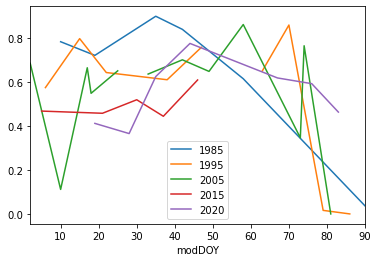

In [87]:
# Plot only whole study area data
df = waterarea[waterarea.unidad == 'Alfafar']

#plotyears = range(1985,2020)
plotyears = [1985,1995,2005,2015,2020]
df = df[df.modyear.isin(plotyears)]
#df.head(100)

# We want to avoid gaps in the graph due to NA values
df.value=df.water_perc.ffill()

# Sort modDOY in order to plot correctly
df = df.sort_values('modDOY', ascending = False).reset_index(drop=True)

fig, ax = plt.subplots()
for label, grp in df.groupby('modyear'):
    grp.plot(x='modDOY', y='water_perc',ax = ax, label = label)


<ipython-input-88-a74289642366>:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.value=df.water_perc.ffill()
MovieWriter imagemagick unavailable; using Pillow instead.


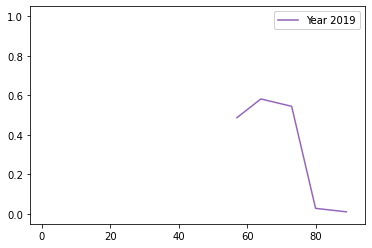

In [88]:
# ANIMATION
# Plot only whole study area data
df = waterarea[waterarea.unidad == 'Alfafar']
# We want to avoid gaps in the graph due to NA values
df.value=df.water_perc.ffill()
# Sort modDOY in order to plot correctly
df = df.sort_values('modDOY', ascending = False).reset_index(drop=True)
plotyears = range(1985,2020)

fig = plt.figure()
camera = Camera(fig)

#fig, ax = plt.subplots(figsize=(9,6)) # empty fig
for i in plotyears:
    t = plt.plot(df.loc[df['modyear']==i,'modDOY'],df.loc[df['modyear']==i,'water_perc'])
    plt.legend(t, [f'Year {i}'])
    camera.snap()
    
animation = camera.animate()
animation_output = os.path.join(out_dir, 'results.gif')
animation.save(animation_output, writer = 'imagemagick')
